In [42]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import copy

In [4]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2021-05-31 13:31:52--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  96.1MB/s    in 10s     

2021-05-31 13:32:02 (74.6 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [5]:
!tar -xvf images.tar

Streaming output truncated to the last 5000 lines.
Images/n02109047-Great_Dane/n02109047_34148.jpg
Images/n02109047-Great_Dane/n02109047_34162.jpg
Images/n02109047-Great_Dane/n02109047_34209.jpg
Images/n02109047-Great_Dane/n02109047_3643.jpg
Images/n02109047-Great_Dane/n02109047_4267.jpg
Images/n02109047-Great_Dane/n02109047_481.jpg
Images/n02109047-Great_Dane/n02109047_5618.jpg
Images/n02109047-Great_Dane/n02109047_5675.jpg
Images/n02109047-Great_Dane/n02109047_5822.jpg
Images/n02109047-Great_Dane/n02109047_5894.jpg
Images/n02109047-Great_Dane/n02109047_5936.jpg
Images/n02109047-Great_Dane/n02109047_6008.jpg
Images/n02109047-Great_Dane/n02109047_6265.jpg
Images/n02109047-Great_Dane/n02109047_6276.jpg
Images/n02109047-Great_Dane/n02109047_6447.jpg
Images/n02109047-Great_Dane/n02109047_6680.jpg
Images/n02109047-Great_Dane/n02109047_7072.jpg
Images/n02109047-Great_Dane/n02109047_7156.jpg
Images/n02109047-Great_Dane/n02109047_7227.jpg
Images/n02109047-Great_Dane/n02109047_744.jpg
Images/n

In [89]:
labels_dic = {}
l = []
for i in os.walk("/content/Images"):
  for f in i[2]:
    label = i[0].split("/")
    label2 = label[3]
    label2 = label2.split("-")
    l.append(label2[1])
sum = 0
for i in l:
  if i not in labels_dic.keys():
    labels_dic[i] = sum
    sum += 1
key_list = list(labels_dic.keys())
values_list = list(labels_dic.values())
print(labels_dic)


{'Shih': 0, 'Irish_terrier': 1, 'cairn': 2, 'collie': 3, 'Samoyed': 4, 'Leonberg': 5, 'Cardigan': 6, 'Border_collie': 7, 'Blenheim_spaniel': 8, 'standard_poodle': 9, 'beagle': 10, 'miniature_pinscher': 11, 'redbone': 12, 'miniature_poodle': 13, 'bluetick': 14, 'English_springer': 15, 'Lakeland_terrier': 16, 'German_shepherd': 17, 'Ibizan_hound': 18, 'Newfoundland': 19, 'Labrador_retriever': 20, 'komondor': 21, 'affenpinscher': 22, 'golden_retriever': 23, 'Bedlington_terrier': 24, 'borzoi': 25, 'Shetland_sheepdog': 26, 'Greater_Swiss_Mountain_dog': 27, 'Brittany_spaniel': 28, 'Sealyham_terrier': 29, 'Great_Dane': 30, 'keeshond': 31, 'Irish_water_spaniel': 32, 'Afghan_hound': 33, 'basenji': 34, 'otterhound': 35, 'Weimaraner': 36, 'Siberian_husky': 37, 'German_short': 38, 'Tibetan_terrier': 39, 'Norwegian_elkhound': 40, 'vizsla': 41, 'Walker_hound': 42, 'flat': 43, 'groenendael': 44, 'Staffordshire_bullterrier': 45, 'clumber': 46, 'pug': 47, 'Saluki': 48, 'Pomeranian': 49, 'Airedale': 50,

In [136]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, path, transforms, llista):
    self.path = path
    self.dataset = []
    self.transforms = transforms
    self.llista = llista
    for i in os.walk(self.path):
      for f in i[2]:
        label = i[0].split("/")
        label2 = label[3]
        label2 = label2.split("-")
        label_final = labels_dic[label2[1]]
        if label2[1] in self.llista:
          self.dataset.append((i[0]+"/"+f, label_final))

  def __getitem__(self, index):
    img = self.dataset[index][0]
    pil_img = Image.open(img).convert('RGB')
    label = self.dataset[index][1]
    img_tensor = self.transforms(pil_img)
    return img_tensor, torch.LongTensor([label])
  
  def __len__(self):
    return len(self.dataset)


min_0, min_1 = 1000, 1000
for i in os.walk("/content/Images"):
  if i[2]:
    for f in i[2]:
      img = i[0]+"/"+f
    img_p = Image.open(img)
    if img_p.size[0] < min_0:
      min_0 = img_p.size[0]
    if img_p.size[1] < min_1:
      min_1 = img_p.size[1]

train_transforms = transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Resize((128, 128))
  ])
test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((128, 128))
  ])

num_classes = 60
llista = list(labels_dic.keys())
llista = llista[:num_classes]

dataset_train = Dataset("/content/Images", train_transforms, llista)
dataset_test = Dataset("/content/Images", test_transforms, llista)

In [137]:
print(len(dataset_train))
d = dataset_train[500]
d[0].shape

10498


torch.Size([3, 128, 128])

In [138]:
indices = torch.randperm(len(dataset_train)).tolist()
train_test_boundary = int(0.7*len(dataset_train))

train = torch.utils.data.Subset(dataset_train, indices[:train_test_boundary])
test = torch.utils.data.Subset(dataset_test, indices[train_test_boundary:])

print(len(test))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

3150


In [139]:
dataloader_train = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, num_workers=2, drop_last = True)
dataloader_test = torch.utils.data.DataLoader(test, batch_size=4, shuffle=False, num_workers=2, drop_last = True)

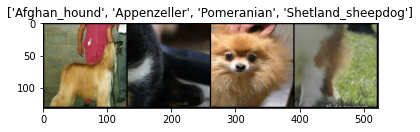

In [140]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels = next(iter(dataloader_train))
l = labels.numpy()
res = []
for i in l:
  position = values_list.index(i)
  res.append((key_list[position]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, res)

In [141]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [146]:
def add_noise(inputs):
  percentatge_noise = 0
  noise = torch.randn_like(inputs)*percentatge_noise
  return inputs + noise

In [147]:
def train_model(model, criterion, optimizer, num_epochs):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epochs):
    for phase in ['train', 'val']:
      
      running_loss = 0.0
      running_corrects = 0

      if phase == 'train':
        model.train()
        for i, data in enumerate(dataloader_train, 0):
          if (4*(i+1))%1000 == 0:
            print(f'{4*(i+1)} images out of {len(train)}')
          
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.squeeze().to(device)
          
          #set 0 gradient parameters
          optimizer.zero_grad()

          #forward
          #print(type(labels))
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            #backward
            loss.backward()
            optimizer.step()
          
          running_loss += loss.item()*inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss/len(train)
        epoch_acc = running_corrects.double()/len(train)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      else:
        model.eval()
        for i, data in enumerate(dataloader_test, 0):
          if (4*(i+1))%1000 == 0:
            print(f'{4*(i+1)} images out of {len(test)}')
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.squeeze().to(device)

          inputs = add_noise(inputs)

          #set 0 gradient parameters
          optimizer.zero_grad()

          #forward
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
          
          running_loss += loss.item()*inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        
        #Canviar el len(train) per len(test)
        epoch_loss = running_loss/len(test)
        epoch_acc = running_corrects.double()/len(test)

        if epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [148]:
%%time
model = train_model(model_ft, criterion, optimizer_ft, num_epochs=25)

1000 images out of 7348
2000 images out of 7348
3000 images out of 7348
4000 images out of 7348
5000 images out of 7348
6000 images out of 7348
7000 images out of 7348
train Loss: 2.1377 Acc: 0.4340
1000 images out of 3150
2000 images out of 3150
3000 images out of 3150
val Loss: 3.1778 Acc: 0.2454
1000 images out of 7348
2000 images out of 7348
3000 images out of 7348
4000 images out of 7348
5000 images out of 7348
6000 images out of 7348
7000 images out of 7348
train Loss: 2.0239 Acc: 0.4582
1000 images out of 3150
2000 images out of 3150
3000 images out of 3150
val Loss: 3.2931 Acc: 0.2695
1000 images out of 7348
2000 images out of 7348
3000 images out of 7348
4000 images out of 7348
5000 images out of 7348
6000 images out of 7348
7000 images out of 7348
train Loss: 1.9483 Acc: 0.4750
1000 images out of 3150
2000 images out of 3150
3000 images out of 3150
val Loss: 3.6801 Acc: 0.1584
1000 images out of 7348
2000 images out of 7348
3000 images out of 7348
4000 images out of 7348
5000

In [72]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader_test):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')  
                position_pred = values_list.index(preds[j])
                position_pred = key_list[position_pred]
                position_real = values_list.index(labels[j])
                position_real = key_list[position_real]
                ax.set_title('predicted: {}, real: {}'.format(position_pred, position_real))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model)

In [112]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [114]:
model_save_name = 'model_60cl_bw_0.516825acc_25ep.pt'
path = f'/content/gdrive/My Drive/UAB/2on/PSIV/{model_save_name}'
torch.save(model_ft.state_dict(), path)